# take2

**GOAL**: Keep It Stupid Simple = KISS.

**Dependencies:**
 - [pocketknives](https://github.com/zjwilliams20/pocketknives)

**References:**
 1. [ilqgames/python](https://github.com/HJReachability/ilqgames/blob/master/python)

In [44]:
from time import perf_counter as pc
import warnings

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from decentralized import split_agents, plot_solve
import decentralized as dec
import pocketknives

π = np.pi

In [45]:
%load_ext autoreload
%autoreload 1
%aimport decentralized.control, decentralized.dynamics, decentralized.cost, \
    decentralized.problem, decentralized.util, decentralized.decentralized

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
%matplotlib ipympl
plt.rcParams['axes.grid'] = True

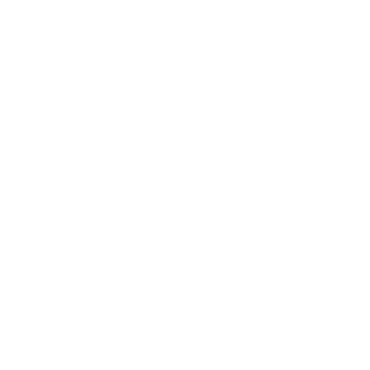

In [19]:
fig = plt.figure(figsize=(3.7, 3.7))
# fig = plt.figure()

## single-agent problem

0/50	J: 432856
1/50	J: 4390.34	μ: 0.5	Δ: 0.5
2/50	J: 4096.25	μ: 0.125	Δ: 0.25
3/50	J: 3473.42	μ: 0.015625	Δ: 0.125
4/50	J: 3428.29	μ: 0.000976562	Δ: 0.0625
5/50	J: 3371.06	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 3263.24	μ: 0	Δ: 0.015625
7/50	J: 3236.37	μ: 0	Δ: 0.0078125
8/50	J: 3211.05	μ: 0	Δ: 0.00390625
9/50	J: 3206.25	μ: 0	Δ: 0.00195312
10/50	J: 3198.65	μ: 0	Δ: 0.000976562


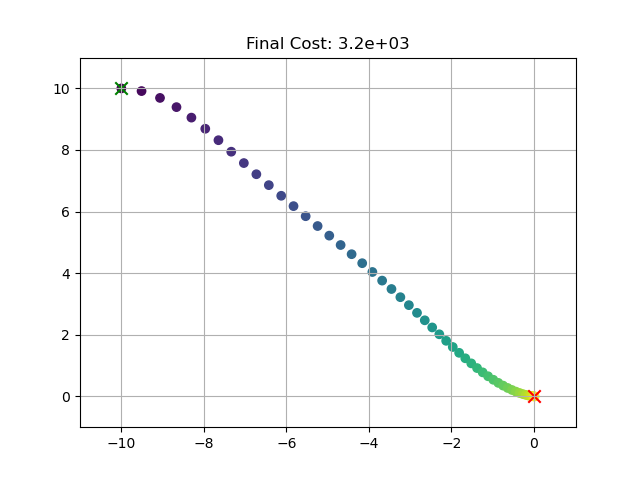

In [47]:
dt = 0.05
N = 50
n_d = 2

x = np.array([-10, 10, 10, 0], dtype=float)
x_goal = np.zeros((4, 1), dtype=float).T

# dynamics = dec.DoubleIntDynamics4D(dt)
dynamics = dec.UnicycleDynamics4D(dt)

Q = np.diag([1., 1, 0, 0])
Qf = 1000 * np.eye(Q.shape[0])
R = np.eye(2)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, x_goal)
plt.draw()

Show equations of motion, which have the form

$$\dot{x} = f(x, u, p)$$

for states

$$
x = \begin{bmatrix} o_x & o_y & o_z & \psi & \theta & \phi & v_x & v_y & v_z & w_x & w_y & w_z \end{bmatrix},
$$

inputs
$$
u = \begin{bmatrix} \tau_x & \tau_y & \tau_z & f_z \end{bmatrix},
$$

and parameters
$$
p = \begin{bmatrix} m & J_x & J_y & J_z & g \end{bmatrix}.
$$

In [48]:
# Single-agent problem for a 12D quadcopter (w/ analytical diff.)
dt = 0.1
N = 40
n_d = 3

x = np.array([2, 2, 0.5 , 0.05, 0, 0, 0.0, 0.0, 0, 0, 0, 0], dtype=float)
x_goal = np.zeros((12, 1), dtype=float).T

dynamics = dec.QuadcopterDynamics12D(dt)

# Q = np.diag([1., 1., 1., 0, 0, 0, 0, 0, 0, 0, 0, 0])
Q = np.diag([1., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Qf = 100 * np.eye(Q.shape[0])
R = np.eye(4)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)

# with warnings.catch_warnings():
    # warnings.filterwarnings("error")
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, x_goal, n_d=n_d)
plt.draw()

0/50	J: 827632
1/50	J: 201987	μ: 0.5	Δ: 0.5
2/50	J: 21930.2	μ: 0.125	Δ: 0.25
3/50	J: 557.848	μ: 0.015625	Δ: 0.125
4/50	J: 231.863	μ: 0.000976562	Δ: 0.0625
5/50	J: 178.035	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 152.891	μ: 0	Δ: 0.015625
7/50	J: 151.232	μ: 0	Δ: 0.0078125
8/50	J: 142.341	μ: 0	Δ: 0.00390625
9/50	J: 139.118	μ: 0	Δ: 0.00195312
10/50	J: 135.08	μ: 0	Δ: 0.000976562
11/50	J: 132.787	μ: 0	Δ: 0.000488281
12/50	J: 131.399	μ: 0	Δ: 0.000244141
13/50	J: 130.31	μ: 0	Δ: 0.00012207
14/50	J: 129.879	μ: 0	Δ: 6.10352e-05
15/50	J: 129.426	μ: 0	Δ: 3.05176e-05
16/50	J: 129.296	μ: 0	Δ: 1.52588e-05
17/50	J: 129.109	μ: 0	Δ: 7.62939e-06


In [5]:
# Single-agent problem for a 6D quadcopter (w/ analytical diff.)
dt = 0.1
N = 40
n_d = 3

x = np.array([2, 2, 0.5 , 0, 0, 0], dtype=float)
x_goal = np.zeros((6, 1), dtype=float).T

dynamics = dec.QuadcopterDynamics6D(dt)

# Q = np.diag([1., 1., 1., 0, 0, 0, 0, 0, 0, 0, 0, 0])
Q = np.diag([1., 1., 1., 1., 1., 1.])
Qf = 100 * np.eye(Q.shape[0])
R = np.eye(3)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)

# with warnings.catch_warnings():
    # warnings.filterwarnings("error")
X, U, J = ilqr.solve(x)

plt.clf()
plot_solve(X, J, x_goal, n_d=n_d)
plt.draw()

0/50	J: 827632
1/50	J: 3912.54	μ: 0.5	Δ: 0.5
2/50	J: 3857.8	μ: 0.125	Δ: 0.25


## Human Agent Alone

In [7]:
dt = 0.1
N = 40
n_d = 3

x = np.array([2, 2, 1.75 , 0, 0, 0], dtype=float)
x_goal = np.zeros((6, 1), dtype=float).T
x_goal[:,2] = 1.75
dynamics = dec.HumanDynamics6D(dt)


Q = np.diag([1., 1., 1., 1., 1., 1.])
Qf = 100 * np.eye(Q.shape[0])
R = np.eye(3)
cost = dec.ReferenceCost(x_goal, Q, R, Qf)

prob = dec.ilqrProblem(dynamics, cost)
ilqr = dec.ilqrSolver(prob, N)

# with warnings.catch_warnings():
    # warnings.filterwarnings("error")
X, U, J = ilqr.solve(x)
plt.clf()

0/50	J: 1120
1/50	J: 602.081	μ: 0.5	Δ: 0.5
2/50	J: 167.359	μ: 0.125	Δ: 0.25
3/50	J: 150.801	μ: 0.015625	Δ: 0.125
4/50	J: 136.326	μ: 0.000976562	Δ: 0.0625
5/50	J: 128.486	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 127.543	μ: 0	Δ: 0.015625
7/50	J: 127.059	μ: 0	Δ: 0.0078125


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

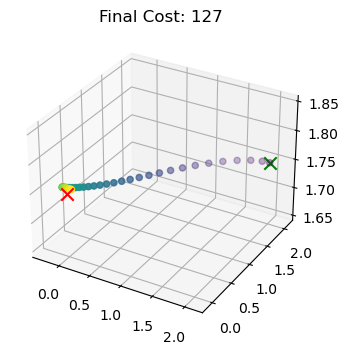

In [11]:
plt.clf()
plt.figure(dpi=100)
plot_solve(X, J, x_goal, n_d=n_d)
plt.draw()


## multi-agent problem

### initializing the scene
Here, we define some initial positions within some distance of each other, and then rotate them about the origin by some random angle to hopefully create some interesting scenarios.

In [12]:
def paper_setup():
    """Hardcoded example with reasonable consistency eyeballed from 
       Potential-iLQR paper
    """
    x0 = np.array([[0.5, 1.5, 0, 0.1,
                    2.5, 1.5, 0, π,
                    1.5, 1.3, 0, π/2]], 
                     dtype=float).T
    x_goal = np.array([[2.5, 1.5, 0, 0, 
                        0.5, 1.5, 0, π, 
                        1.5, 2.2, 0, π/2]]).T
    return x0, x_goal

def dec_test_setup():
    x0, x_goal = paper_setup()
    x0_other = np.array([[5, 5, 0, 0,
                          6, 6, 0, π/4]]).T
    x_goal_other = np.array([[6, 4, 0, -π/2,
                              4, 6, 0, π/4]]).T
    
    x0 = np.concatenate([x0, x0_other]) 
    x_goal = np.concatenate([x_goal, x_goal_other])    
    
    return x0, x_goal

## quadcopter w/ humans

In [49]:
n_states = 6
n_controls = 3
n_agents = 3

x_dims = [n_states] * n_agents
u_dims = [n_controls] * n_agents
n_dims = [3, 2, 2]

dt = 0.1
N = 20
radius = 0.5

x0 = np.array([
    #[-0.2, 2, 0, -π/2, 0, 0], 
    [2, 2.4, 1.4, 0, 0, 0],
    [-2, 1.6, 1.75, -0.01, -0.01, 0.0],
    [0.5, 1.0, 1.73, 0.01, -0.01, 0.0]
]).flatten() 
xf = np.array([
    #[0.4, -2, 0, -π/2, 0, 0], 
    [-2, -2, 1.6, 0, 0, 0],
    [1, -1.9, 1.75, 0, 0, 0],
    [1, 1.9, 1.73, 0, 0, 0]
]).flatten() 

Q = np.diag([10, 10, 10, 10, 10, 10])
R = np.diag([0, 1, 1])
Qf = 1e3 * np.eye(n_states)

models = [dec.QuadcopterDynamics6D, dec.HumanDynamics6D, dec.HumanDynamics6D]
ids = [100 + i for i in range(n_agents)]
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_, model in zip(ids, models)])

goal_costs = [
    dec.ReferenceCost(xf_i, Q.copy(), R.copy(), Qf.copy(), id_)
    for xf_i, id_, x_dim, u_dim in zip(
        dec.split_agents_gen(xf, x_dims), ids, x_dims, u_dims
    )
]
prox_cost = dec.ProximityCost(x_dims, radius, n_dims)
game_cost = dec.GameCost(goal_costs, prox_cost)

problem = dec.ilqrProblem(dynamics, game_cost)
solver = dec.ilqrSolver(problem, N)

In [50]:
len(set(n_dims))

2

In [51]:
U0 = np.zeros((N, n_agents*n_controls))
X, U, J, _ = dec.solve_centralized(solver, x0, U0, ids, True)

0/50	J: 884227
1/50	J: 46086.1	μ: 0.5	Δ: 0.5
2/50	J: 36190.5	μ: 0.125	Δ: 0.25
3/50	J: 33653.3	μ: 0.015625	Δ: 0.125
4/50	J: 25450.2	μ: 0.000976562	Δ: 0.0625
5/50	J: 20078.6	μ: 3.05176e-05	Δ: 0.03125
6/50	J: 17636.6	μ: 0	Δ: 0.015625
7/50	J: 12208.6	μ: 0	Δ: 0.0078125
8/50	J: 12107.3	μ: 0	Δ: 0.00390625
9/50	J: 10361	μ: 0	Δ: 0.00195312
10/50	J: 8366.71	μ: 0	Δ: 0.000976562
11/50	J: 7021.73	μ: 0	Δ: 0.000488281
12/50	J: 6891.43	μ: 0	Δ: 0.000244141
13/50	J: 6805.71	μ: 0	Δ: 0.00012207
14/50	J: 6481.89	μ: 0	Δ: 6.10352e-05
15/50	J: 6305.66	μ: 0	Δ: 3.05176e-05


In [52]:
U0 = np.zeros((N, n_agents*n_controls))
X0 = np.tile(x0, (N+1, 1))
X_dec, U_dec, J_dec, _ = dec.solve_decentralized(problem, X0, U0, radius, verbose=True)

Interaction Graph: {100: [100], 101: [101], 102: [102]}
Problem 100: [100]
Took 0.04538139997748658 seconds

Problem 101: [101]
Took 0.055417300027329475 seconds

Problem 102: [102]
Took 0.039104499970562756 seconds



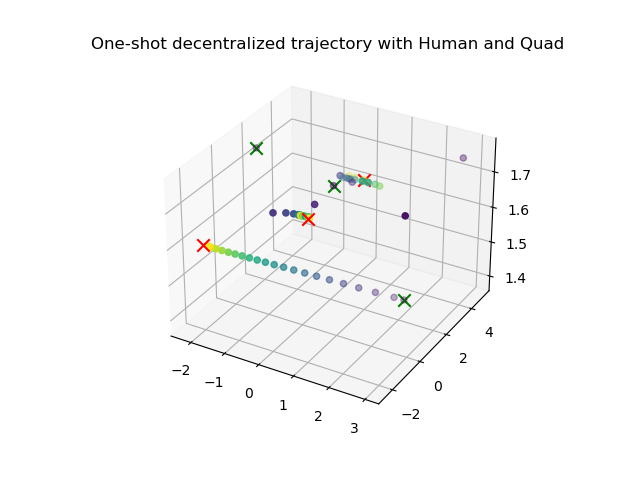

In [53]:
plt.clf()
plt.figure(dpi=100)
plot_solve(X_dec, J_dec, xf, x_dims, n_d=3)
plt.title('One-shot decentralized trajectory with Human and Quad')
plt.draw()

In [54]:
#With receding-horizon:
# %%time
n_d = 3
step_size = 1
U0 = np.zeros((N, n_agents*n_controls))
N = 6
radius = 0.25
X_rhc, U_rhc, J_rhc = dec.solve_rhc(
    problem, x0, N, radius,
    centralized=False,
    n_d=n_d,
    step_size=step_size, 
    dist_converge=0.1,
    verbose=True,
    t_kill=step_size*dt,
    t_diverge=None
)

t: 0
t: 0.1
t: 0.2
t: 0.3
t: 0.4
t: 0.5
t: 0.6
t: 0.7
t: 0.8
t: 0.9
t: 1
t: 1.1
t: 1.2
t: 1.3
t: 1.4
t: 1.5
t: 1.6
t: 1.7
t: 1.8
t: 1.9
t: 2


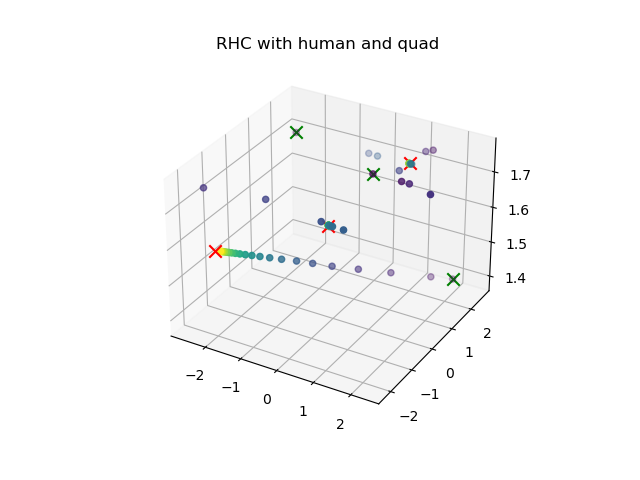

In [55]:
plt.clf()
plt.figure(dpi=100)
plot_solve(X_rhc, J_rhc, xf, x_dims, n_d=3)
plt.title('RHC with human and quad')
plt.draw()

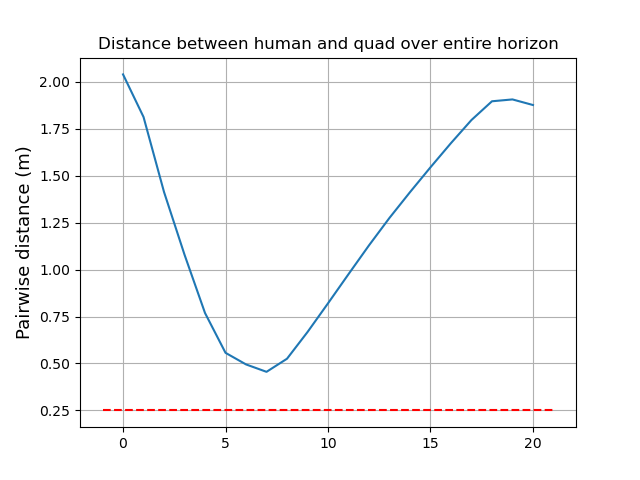

In [94]:
# plt.clf()
plt.figure()
plt.plot(dec.compute_pairwise_distance(X, x_dims, n_dims[1]))
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.title('Distance between human and quad over entire horizon')
plt.ylabel('Pairwise distance (m)',fontsize=13)
plt.draw()

To be consistent between simulations, we normalize for the scale of the setup by computing the *energy*, or the sum of distances from the origin of the points. This should be the same for all runs.

## Quadcopters only (5)

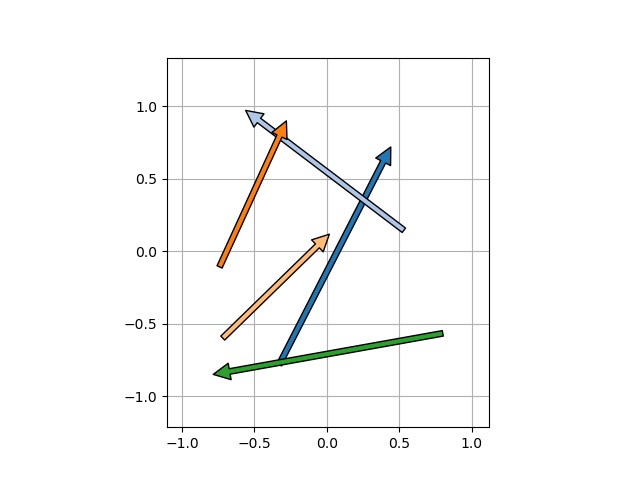

In [69]:
n_states = 6
n_controls = 3
n_agents = 5

x_dims = [n_states] * n_agents
u_dims = [n_controls] * n_agents
n_dims = [3, 3, 3, 3, 3]

ENERGY = 20.0
n_d = 3

# x0, x_goal = paper_setup()
# x0, x_goal = car_setup()
# x0, x_goal = bike_setup()
# x0, x_goal = double_int_setup()
# x0, x_goal = dec_test_setup()
x0, x_goal = dec.random_setup(
    n_agents, n_states, 
    is_rotation=False, 
    rel_dist=2.0, 
    var=1.0, 
    n_d=n_d, 
    random=True
)

plt.clf()
plt.figure()
plt.gca().set_aspect('equal')
X = np.dstack([
    x0.reshape(n_agents, n_states), 
    x_goal.reshape(n_agents, n_states)
]).swapaxes(1,2)
for i, Xi in enumerate(X):
    plt.annotate('', Xi[1,:2], Xi[0,:2], 
                 arrowprops=dict(facecolor=plt.cm.tab20.colors[i]))
pocketknives.set_bounds(X.reshape(-1, n_states), zoom=0.2)
plt.draw()

In [70]:
x0 = x0.flatten()

In [93]:
dt = 0.1

tol = 1e-3
ids = [100 + i for i in range(n_agents)]

Q = np.diag([10, 10, 10, 10, 10, 10])
R = np.diag([0, 1, 1])
Qf = 1e3 * np.eye(n_states)

models = [dec.QuadcopterDynamics6D, dec.QuadcopterDynamics6D, dec.QuadcopterDynamics6D,dec.QuadcopterDynamics6D,dec.QuadcopterDynamics6D]
ids = [100 + i for i in range(n_agents)]
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_, model in zip(ids, models)])

goal_costs = [
    dec.ReferenceCost(xf_i, Q.copy(), R.copy(), Qf.copy(), id_)
    for xf_i, id_, x_dim, u_dim in zip(
        dec.split_agents_gen(x_goal, x_dims), ids, x_dims, u_dims
    )
]
radius = 0.5
prox_cost = dec.ProximityCost(x_dims, radius, n_dims)
game_cost = dec.GameCost(goal_costs, prox_cost)
N = 40
problem = dec.ilqrProblem(dynamics, game_cost)
solver = dec.ilqrSolver(problem, N)

In [94]:
U0 = np.zeros((N, n_agents*n_controls))
X0 = np.tile(x0, (N+1, 1))
X_dec, U_dec, J_dec, _ = dec.solve_decentralized(problem, X0, U0, radius, verbose=True)

Interaction Graph: {100: [100, 102, 103], 101: [101, 104], 102: [100, 102, 103], 103: [100, 102, 103], 104: [101, 104]}
Problem 100: [100, 102, 103]
Took 0.09819629997946322 seconds

Problem 101: [101, 104]
Took 0.22607820003759116 seconds

Problem 102: [100, 102, 103]
Took 0.09213940001791343 seconds

Problem 103: [100, 102, 103]
Took 0.09394699998665601 seconds

Problem 104: [101, 104]
Took 0.2242602999904193 seconds



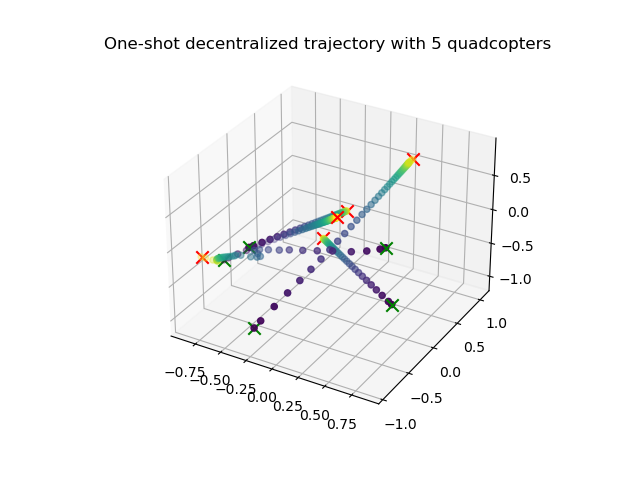

In [95]:
plt.clf()
plt.figure(dpi=100)
plot_solve(X_dec, J_dec, x_goal, x_dims, n_d=3)
plt.title('One-shot decentralized trajectory with 5 quadcopters')
plt.draw()

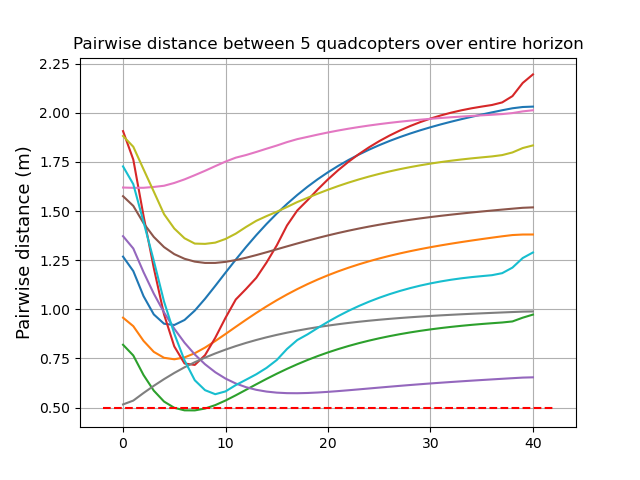

In [96]:
plt.figure()
plt.plot(dec.compute_pairwise_distance(X_dec, x_dims, n_dims[1]))
plt.hlines(radius, *plt.xlim(), 'r', ls='--')
plt.title('Pairwise distance between 5 quadcopters over entire horizon')
plt.ylabel('Pairwise distance (m)',fontsize=13)
plt.draw()

In [97]:
#with receding horizon:
n_d = 3
step_size = 1
U0 = np.zeros((N, n_agents*n_controls))
N = 10
radius = 0.5
X_rhc, U_rhc, J_rhc = dec.solve_rhc(
    problem, x0, N, radius,
    centralized=False,
    n_d=n_d,
    step_size=step_size, 
    dist_converge=0.1,
    verbose=True,
    t_kill=step_size*dt,
    t_diverge=None
)

t: 0
t: 0.1
t: 0.2
t: 0.3
t: 0.4
t: 0.5
t: 0.6
t: 0.7
t: 0.8
t: 0.9
t: 1
t: 1.1
t: 1.2
t: 1.3
t: 1.4
t: 1.5
t: 1.6
t: 1.7
t: 1.8
t: 1.9
t: 2
t: 2.1
t: 2.2
t: 2.3
t: 2.4


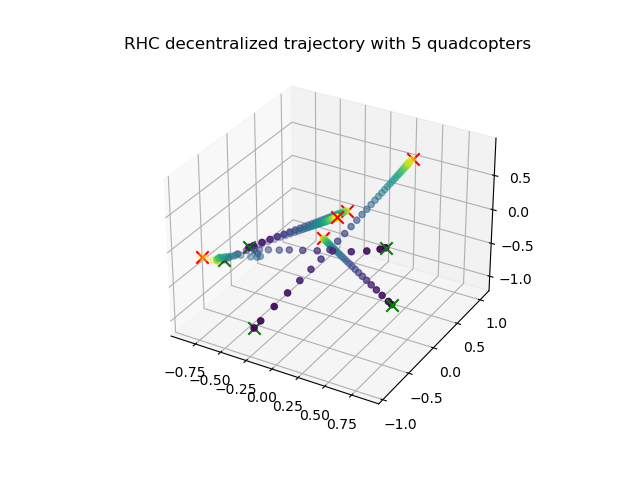

In [99]:
plt.clf()
plt.figure(dpi=100)
plot_solve(X_dec, J_dec, x_goal, x_dims, n_d=3)
plt.title('RHC decentralized trajectory with 5 quadcopters')
plt.draw()

In [16]:
graph = dec.define_inter_graph_threshold(X, radius, x_dims, ids)
graph

{100: [100, 101, 102], 101: [100, 101, 102], 102: [100, 101, 102]}

## Quadcopters only (3):


In [136]:
n_states = 6
n_controls = 3
n_agents = 3

x_dims = [n_states] * n_agents
u_dims = [n_controls] * n_agents
n_dims = [3, 3, 3]

dt = 0.1
N = 50
radius = 0.5

x0 = np.array([
    #[-0.2, 2, 0, -π/2, 0, 0], 
    [0, 1, 1.0, 0, 0, 0],
    [2, -1, 1.0, 0, 0, 0],
    [-1, -2, 1.0, 0, 0, 0]
]).flatten() 
xf = np.array([
    #[0.4, -2, 0, -π/2, 0, 0], 
    [1.0, -2.0, 2.0, 0, 0, 0],
    [-1.0, 0.0, 2.2, 0, 0, 0],
    [1.0, 1.0, 1.8, 0, 0, 0]
]).flatten() 

Q = np.diag([10, 10, 10, 10, 10, 10])
R = np.diag([0, 1, 1])*0.1
Qf = 1e3 * np.eye(n_states)

models = [dec.QuadcopterDynamics6D, dec.HumanDynamics6D, dec.HumanDynamics6D]
ids = [100 + i for i in range(n_agents)]
dynamics = dec.MultiDynamicalModel([model(dt, id_) for id_, model in zip(ids, models)])

goal_costs = [
    dec.ReferenceCost(xf_i, Q.copy(), R.copy(), Qf.copy(), id_)
    for xf_i, id_, x_dim, u_dim in zip(
        dec.split_agents_gen(xf, x_dims), ids, x_dims, u_dims
    )
]
prox_cost = dec.ProximityCost(x_dims, radius, n_dims)
game_cost = dec.GameCost(goal_costs, prox_cost)

problem = dec.ilqrProblem(dynamics, game_cost)
solver = dec.ilqrSolver(problem, N)

In [137]:
U0 = np.zeros((N, n_agents*n_controls))
X0 = np.tile(x0, (N+1, 1))
X_dec, U_dec, J_dec, _ = dec.solve_decentralized(problem, X0, U0, radius, verbose=True)

Interaction Graph: {100: [100], 101: [101], 102: [102]}
Problem 100: [100]
Took 0.06923989998176694 seconds

Problem 101: [101]
Took 0.021908099995926023 seconds

Problem 102: [102]
Took 0.02046379999956116 seconds



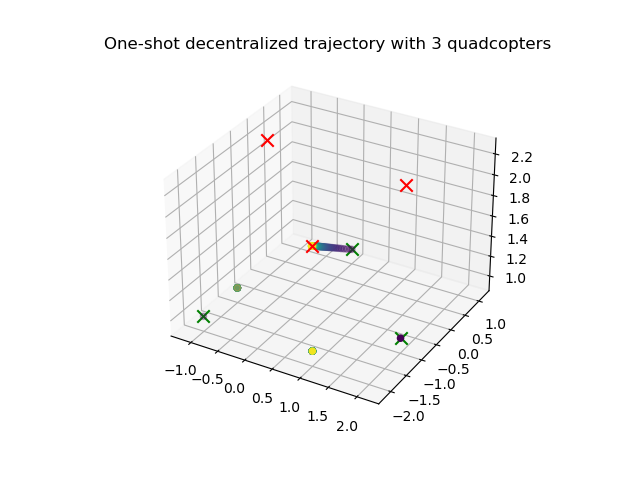

In [138]:
plt.clf()
plt.figure(dpi=100)
plot_solve(X_dec, J_dec, xf, x_dims, n_d=3)
plt.title('One-shot decentralized trajectory with 3 quadcopters')
plt.draw()

In [141]:
#with receding horizon:
n_d = 3
step_size = 5
U0 = np.zeros((N, n_agents*n_controls))
N = 10
radius = 0.5
X_rhc, U_rhc, J_rhc = dec.solve_rhc(
    problem, x0, N, radius,
    centralized=False,
    n_d=n_d,
    step_size=step_size, 
    dist_converge=0.15,
    verbose=True,
    t_kill=step_size*dt,
    t_diverge=None
)

t: 0
t: 0.5
t: 1
t: 1.5
t: 2
t: 2.5
t: 3
t: 3.5
t: 4
t: 4.5
t: 5
t: 5.5
t: 6
t: 6.5
t: 7
t: 7.5
t: 8
t: 8.5
t: 9
t: 9.5
t: 10
t: 10.5
t: 11
t: 11.5
t: 12
t: 12.5
t: 13
t: 13.5
t: 14
t: 14.5
t: 15
t: 15.5
t: 16
t: 16.5
t: 17
t: 17.5
t: 18
t: 18.5
t: 19
t: 19.5
t: 20
t: 20.5
t: 21
t: 21.5
t: 22
t: 22.5
t: 23
t: 23.5
t: 24
t: 24.5
t: 25
t: 25.5
t: 26
t: 26.5
t: 27
t: 27.5
t: 28
t: 28.5
t: 29
t: 29.5
t: 30
t: 30.5
t: 31
t: 31.5
t: 32
t: 32.5
t: 33
t: 33.5
t: 34
t: 34.5
t: 35
t: 35.5
t: 36
t: 36.5
t: 37
t: 37.5
t: 38
t: 38.5
t: 39
t: 39.5
t: 40
t: 40.5
t: 41
t: 41.5
t: 42
t: 42.5
t: 43
t: 43.5
t: 44
t: 44.5
t: 45
t: 45.5
t: 46
t: 46.5
t: 47
t: 47.5
t: 48
t: 48.5
t: 49
t: 49.5
t: 50
t: 50.5
t: 51
t: 51.5
t: 52
t: 52.5
t: 53
t: 53.5
t: 54
t: 54.5
t: 55
t: 55.5
t: 56
t: 56.5
t: 57
t: 57.5
t: 58
t: 58.5
t: 59
t: 59.5
t: 60
t: 60.5
t: 61
t: 61.5
t: 62
t: 62.5
t: 63
t: 63.5
t: 64
t: 64.5
t: 65
t: 65.5
t: 66
t: 66.5
t: 67
t: 67.5
t: 68
t: 68.5
t: 69
t: 69.5
t: 70
t: 70.5
t: 71
t: 71.5
t: 72
t: 72.

KeyboardInterrupt: 

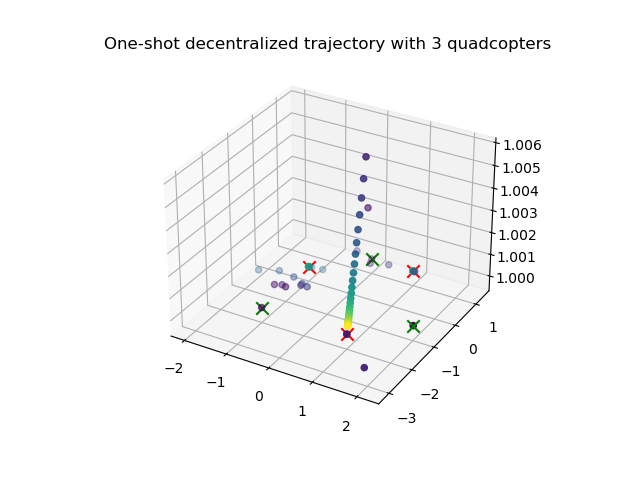

In [135]:
plt.clf()
plt.figure(dpi=100)
plot_solve(X_rhc, J_rhc, xf, x_dims, n_d=3)
plt.title('RHC decentralized trajectory with 3 quadcopters')
plt.draw()

## animation

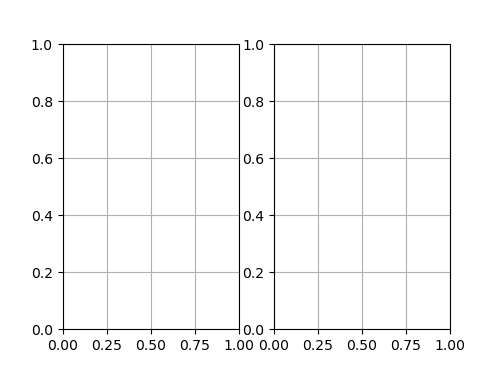

TypeError: 'float' object is not subscriptable

TypeError: 'float' object is not subscriptable

In [36]:
_, axes = plt.subplots(1, 2, figsize=(5.0, 3.7))

In [37]:
def setup(axes, X, x_goal, x_dims, radius):
    
    ax1, ax2 = axes
    n_agents = len(x_dims)
    handles1 = []
    for i in range(n_agents):
        handles1.append((
            ax1.plot(0, c=plt.cm.tab20.colors[2*i], marker='o', markersize=4)[0],
            ax1.add_artist(plt.Circle(np.nan, radius, color='k', fill=True, alpha=0.3, lw=2)),
        ))
        
    for xg in split_agents(x_goal, x_dims):
        ax1.scatter(xg[0,0], xg[0,1], c='r', marker='x', zorder=10)

    X_cat = np.vstack(split_agents(X, x_dims))
    pocketknives.set_bounds(X_cat, axes[0], zoom=0.15)
    plt.draw()
    
    handles2 = []
    n_pairs = pocketknives.nchoosek(n_agents, 2)
    for i in range(n_pairs):
        handles2.append(ax2.plot(0, c=plt.cm.tab20.colors[2*i])[0])
    ax2.hlines(radius, 0, X.shape[0], 'r', ls='--')
    ax2.set_ylim(0.0, distances.max())
        
    return handles1, handles2
    
def animate(t, handles1, handles2, X, x_dims, x_goal, distances):
    """Animate the solution into a gif"""
    
    for (i, xi), hi in zip(enumerate(split_agents(X, x_dims)), handles1):
        hi[0].set_xdata(xi[:t,0])
        hi[0].set_ydata(xi[:t,1])
        hi[1].set_center(xi[t-1,:2])
        
    for i, hi in enumerate(handles2):
        hi.set_xdata(range(t))
        hi.set_ydata(distances[:t, i])
    
    plt.draw()
    

In [38]:
distances = dec.compute_pairwise_distance(X, x_dims).T
handles1, handles2 = setup(axes, X, x_goal.flatten(), x_dims, radius)
animate(10, handles1, handles2, X, x_dims, x_goal, distances)
plt.draw()

AttributeError: module 'pocketknives' has no attribute 'nchoosek'

In [ ]:
handles = setup(axes, X, x_goal.flatten(), x_dims, radius)
anim = FuncAnimation(
    plt.gcf(), 
    animate, 
    frames=N+1, 
    fargs=(*handles, X, x_dims, x_goal, distances))
anim.save('traj.gif', fps=5)

## old

In [39]:
# Old RHC for plotting...
rhc = dec.RecedingHorizonController(x0, ilqr, step_size=5)
U0 = np.zeros((ilqr.N, ilqr.n_u))
for Xi, Ui, Ji in rhc.solve(U0, J_converge=101.0, tol=tol, verbose=False):
    plt.cla()
    plot_solve(Xi, Ji, x_goal.T, x_dims)
    fig.canvas.draw()

--------------------------------------------------
Horizon 0
--------------------------------------------------
Horizon 1
--------------------------------------------------
Horizon 2
--------------------------------------------------
Horizon 3
--------------------------------------------------
Horizon 4
--------------------------------------------------
Horizon 5
--------------------------------------------------
Horizon 6
--------------------------------------------------
Horizon 7
--------------------------------------------------
Horizon 8
--------------------------------------------------
Horizon 9
--------------------------------------------------
Horizon 10
--------------------------------------------------
Horizon 11
--------------------------------------------------
Horizon 12
--------------------------------------------------
Horizon 13
--------------------------------------------------
Horizon 14
--------------------------------------------------
Horizon 15
------------------

KeyboardInterrupt: 

In [41]:
# Manual decentralized RHC for plotting...
step_size = 5
Xi = np.tile(x0.T, (N,1))
Ui = np.zeros((N, dynamics.n_u))
X_dec = np.zeros((0, dynamics.n_x))
U_dec = np.zeros((0, dynamics.n_u))
Ji = np.inf
J_converge = 100.0

while Ji >= J_converge:
    Xi, Ui, Ji = dec.solve_decentralized(prob, Xi, Ui, radius)
    
    X_dec = np.r_[X_dec, Xi[:step_size]]
    U_dec = np.r_[U_dec, Ui[:step_size]]
    
    # Seed the next solve by staying at the last visited state.
    Xi = np.r_[Xi[step_size:], np.tile(Xi[-1], (step_size, 1))]
    Ui = np.r_[Ui[step_size:], np.zeros((step_size, dynamics.n_u))]
    
    plt.cla()
    plot_solve(Xi[:step_size], Ji, x_goal.T, x_dims)
    fig.canvas.draw()

================================================================================Interaction Graph: {100: [100, 102], 101: [101], 102: [100, 102], 103: [103], 104: [104]}
Problem 100: [100, 102]
Took 0.31802650000099675 seconds

Problem 101: [101]
Took 0.024653300000863965 seconds

Problem 102: [100, 102]
Took 0.33756650000032096 seconds

Problem 103: [103]
Took 0.020773000000190223 seconds

Problem 104: [104]
Took 0.06859970000004978 seconds



ValueError: too many values to unpack (expected 3)